# 진동 감쇠 및 센싱 메타구조 최적화

![vibration_overview](picture/vibration_overview.png)

- 다기능성 진동 메타물질 설계 및 최적화    
- 총 4개의 구조 설계 파라미터 및 주파수 대역에 대한 진동 및 전압 데이터 확보    
- 딥러닝 기반 예측 모델 적용 및 NSGA 알고리즘을 통한 최적화

In [2]:
!pip install tensorflow

  Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.11.0-cp37-cp37m-win_amd64.whl (266.3 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp37-cp37m-win_amd64.whl (1.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached protobuf-3.19.6-cp37-cp37m-win_amd64.whl (896 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached h5py-3.8.0-cp37-cp37m-win_amd64.whl (2.6 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached requests-2.31.0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
!pip install numpy

In [ ]:
!pip install pymoo==0.6.1.1

In [1]:
# %%
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input,Dense, LeakyReLU, BatchNormalization, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import keras.backend as K
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D, Flatten
import os 
import re

# 데이터 로드

In [ ]:
# GitHub 저장소 클론
!git clone https://github.com/srpark9187/DIC2025.git

# 작업 경로 이동
%cd DIC2025

In [ ]:
import zipfile
import os

# 압축 파일들이 들어 있는 폴더 경로
data_folder = './data'

# data 폴더 내 모든 zip 파일을 대상으로 압축 해제
for filename in os.listdir(data_folder):
    if filename.endswith('.zip'):
        zip_path = os.path.join(data_folder, filename)

        print(f"🔓 압축 해제 중: {filename} → {data_folder}")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_folder)  # 하위 폴더 없이 현재 data 폴더로 해제

print("✅ 모든 zip 파일 압축 해제 완료 (하위폴더 없이)!")


## 구조 설계 파라미터에 따른 주파수별 transmittance, voltage 데이터 불러오기

파일명 : "data_a_0.0_b_0.0_t1_0.6_t2_0.6"    
(구조 설계 파라미터 4개에 대한 수치로 표현)    
    
파일내용 : 1Hz ~ 100Hz 범위에서 transmittance 및 voltage 값    
(acc 는 사용하지 않음)

![vibration_data](picture/vibration_data.png)

In [2]:

# 데이터 로드 함수
def load_data_from_directory(directory):
    pattern = re.compile(r'data_a_(?P<a>[-+]?[0-9]*\.?[0-9]+)_b_(?P<b>[-+]?[0-9]*\.?[0-9]+)_t1_(?P<t1>[-+]?[0-9]*\.?[0-9]+)_t2_(?P<t2>[-+]?[0-9]*\.?[0-9]+)\.csv')
    dataframe_list = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            match = pattern.match(file)

            # 파일 이름이 정규표현식과 일치하는 경우
            if match:
                file_path = os.path.join(directory, file)
                df = pd.read_csv(file_path)
                a = float(match.group('a'))
                b = float(match.group('b'))
                t1 = float(match.group('t1'))
                t2 = float(match.group('t2'))

                # 각 열을 리스트로 추출한 후, 다음 조건에 맞는 행만 통합 리스트에 저장
                frequencies = df['Index'].tolist()
                transmittances = df['Transmittance'].tolist()
                volt_values = df['Volt'].tolist()
                for freq, trans, volt in zip(frequencies, transmittances, volt_values):
                    if 0 <= freq <= 100:
                        dataframe_list.append({
                            'a': a,
                            'b': b,
                            't1': t1,
                            't2': t2,
                            'Frequency': freq,
                            'Transmittance': trans,
                            'Volt': volt
                        })
            else:
                print(f"Filename {file} does not match the pattern")
    return pd.DataFrame(dataframe_list)

# 데이터 디렉토리 경로
data_directory = r'data/vibration'

# 데이터 로드
df = load_data_from_directory(data_directory)

print(f"Data shape: {df.shape}")
print("Columns:", df.columns.tolist())

Data shape: (230400, 7)
Columns: ['a', 'b', 't1', 't2', 'Frequency', 'Transmittance', 'Volt']


## 데이터 전처리

### Outlier 제거 및 데이터 증강

- 기존 데이터 분포에서 매우 벗어나는 데이터 제거
- 부족한 데이터 증강    
(실습에 사용되는 데이터는 outlier 가 포함되어있지 않음)

In [ ]:
# %% 전처리 및 증강 함수 정의
def preprocess_and_augment_data(df):
    initial_size = df.shape[0]  # 초기 데이터 크기

    def remove_outliers_by_iqr(df, column, A):

        # Q1 (25% 분위수), Q3 (75% 분위수)를 기준으로 IQR 계산
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + A * IQR
        print(f"{column} IQR 기반 상한값 제거: {upper_bound}")
        return df[df[column] <= upper_bound]

    # Transmittance, Voltage 에 대한 
    df = remove_outliers_by_iqr(df, 'Transmittance', 50)
    df = remove_outliers_by_iqr(df, 'Volt', 5e4)
    df = df.dropna()
    
    # 전처리 후 데이터 크기 저장
    final_size_after_preprocessing = df.shape[0]
    print(f"전처리로 제거된 데이터 비율: {(initial_size - final_size_after_preprocessing) / initial_size * 100:.2f}%")

    # 데이터 증강
    ## 특정 전압 이상의 데이터 증강
    def augment_volt_peaks(df, volt_factor, volt_threshold):
        volt_peaks = df[df['Volt'] >= volt_threshold]
        print(f"Volt ≥ {volt_threshold} 데이터 수: {volt_peaks.shape[0]} → {volt_factor}배 증강")
        augmented = pd.concat([volt_peaks] * volt_factor, ignore_index=True)
        return pd.concat([df, augmented], ignore_index=True)
    
    df = augment_volt_peaks(df, volt_factor=1, volt_threshold=0.00001)
    df = augment_volt_peaks(df, volt_factor=1, volt_threshold=0.0001)
    df = augment_volt_peaks(df, volt_factor=1, volt_threshold=0.001)

    print(f"증강 후 최종 데이터 수: {df.shape[0]}")
    return df

# %% 전처리 및 증강 적용
df_processed = preprocess_and_augment_data(df)
print(df_processed.shape)

Transmittance IQR 기반 상한값 클리핑: 219.10751353829886
Volt IQR 기반 상한값 클리핑: 1.6780768824192605
전처리로 제거된 데이터 비율: 0.00%
Volt ≥ 1e-05 데이터 수: 230400 → 1배 증강
Volt ≥ 0.0001 데이터 수: 117462 → 1배 증강
Volt ≥ 0.001 데이터 수: 16860 → 1배 증강
증강 후 최종 데이터 수: 595122
(595122, 7)


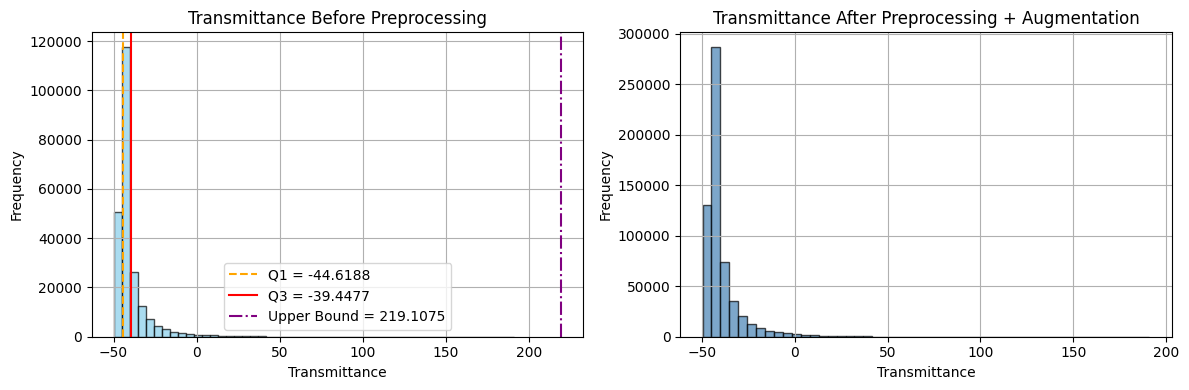

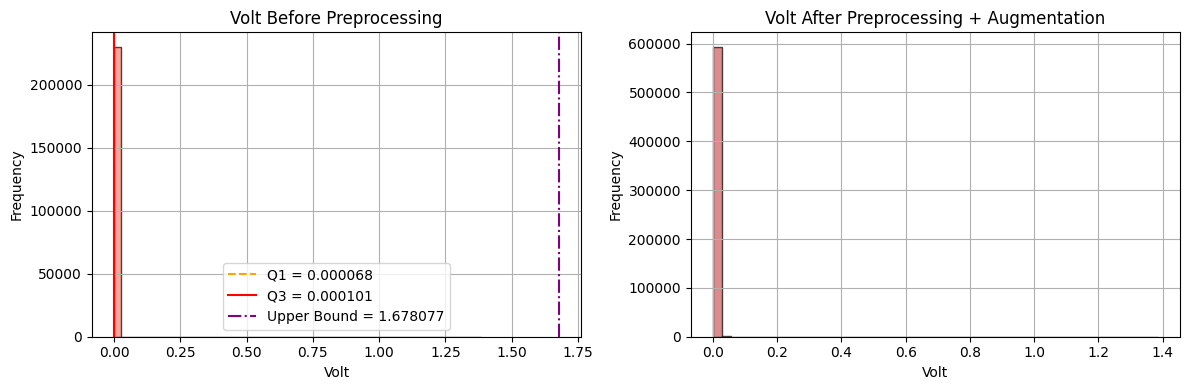

In [5]:
import matplotlib.pyplot as plt

# 전처리 전 사분위수 및 상한값 계산
q1_trans = df['Transmittance'].quantile(0.25)
q3_trans = df['Transmittance'].quantile(0.75)
iqr_trans = q3_trans - q1_trans
upper_trans = q3_trans + 50 * iqr_trans  # A=50 사용

q1_volt = df['Volt'].quantile(0.25)
q3_volt = df['Volt'].quantile(0.75)
iqr_volt = q3_volt - q1_volt
upper_volt = q3_volt + 5e4 * iqr_volt  # A=5e4 사용

# ===============================
# Transmittance subplot
# ===============================
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# 왼쪽: 전처리 전 Transmittance
axs[0].hist(df['Transmittance'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axs[0].axvline(q1_trans, color='orange', linestyle='--', label=f'Q1 = {q1_trans:.4f}')
axs[0].axvline(q3_trans, color='red', linestyle='-', label=f'Q3 = {q3_trans:.4f}')
axs[0].axvline(upper_trans, color='purple', linestyle='-.', label=f'Upper Bound = {upper_trans:.4f}')
axs[0].set_title('Transmittance Before Preprocessing')
axs[0].set_xlabel('Transmittance')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].grid(True)

# 오른쪽: 전처리 후 Transmittance
axs[1].hist(df_processed['Transmittance'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axs[1].set_title('Transmittance After Preprocessing + Augmentation')
axs[1].set_xlabel('Transmittance')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# ===============================
# Volt subplot
# ===============================
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# 왼쪽: 전처리 전 Volt
axs[0].hist(df['Volt'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axs[0].axvline(q1_volt, color='orange', linestyle='--', label=f'Q1 = {q1_volt:.6f}')
axs[0].axvline(q3_volt, color='red', linestyle='-', label=f'Q3 = {q3_volt:.6f}')
axs[0].axvline(upper_volt, color='purple', linestyle='-.', label=f'Upper Bound = {upper_volt:.6f}')
axs[0].set_title('Volt Before Preprocessing')
axs[0].set_xlabel('Volt')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].grid(True)

# 오른쪽: 전처리 후 Volt
axs[1].hist(df_processed['Volt'], bins=50, color='indianred', edgecolor='black', alpha=0.7)
axs[1].set_title('Volt After Preprocessing + Augmentation')
axs[1].set_xlabel('Volt')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()


원본 데이터셋에 preprocessing 및 data augmentation 적용 결과

![vibration_transmittance_1](picture/vibration_transmittance.png)

![vibration_voltage](picture/vibration_voltage.png)

## 증강된 데이터셋에 대해 normalization (min_max normalization)

scaler_X :      
[a, b, t1, t2, frequency] 의 각 column 에 대해 최대값:최소값을 0 ~ 1 로 normalization

scaler_y :      
[Transmittance, Voltage] 의 각 column 에 대해 최대값:최소값을 0 ~ 1 로 normalization

In [6]:
# %% 입력/출력 변수 정의 및 정규화

features = ['a', 'b', 't1', 't2', 'Frequency']
target = ['Transmittance', 'Volt']

X = df_processed[features]
y = df_processed[target]
df1=df_processed

# 입력 정규화 (구조 설계 파라미터 및 주파수)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# 타겟 정규화 (Transmittance, Voltage)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


## 딥러닝 기반 예측 모델 구현

![vibration_deeplearning](picture/vibration_deeplearning.png)

입력 (5) : 구조 설계 파라미터 (4) + 주파수 (1)    
출력 (2) : transmittance (1) + voltage (1)    
    
layer depth : 7, layer unit : 896    
(하이퍼파라미터는 Bayesian optimization 을 통해 최적화)

In [ ]:
# DNN 모델 생성 함수
def create_dnn_model(units, layers, dropout, learning_rate, volt_weight=100.0):

    model = Sequential()

    for _ in range(layers):
        model.add(Dense(units, kernel_initializer='he_normal'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(2))  # 출력층 (Transmittance, Volt)

    def custom_weighted_loss(y_true, y_pred):
        trans_loss = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))
        volt_loss = K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))
        return trans_loss + volt_weight * volt_loss

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=custom_weighted_loss,  # 가중치 조절된 커스텀 손실
        metrics=['mae']  # 전체 평균 MAE 출력
    )
    return model

# ✅ 모델 생성 먼저 실행
## 하이퍼 파라미터는 bayesian optimization 을 통해 최적화
dnn_model = create_dnn_model(
    units=896,
    layers=7,
    dropout=0.10570193500101584,
    learning_rate=0.0011323133356792667 / 2,
    volt_weight=100.0  # Volt 쪽 중요도 증가
)

# 모델 훈련
history = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=30000, batch_size=2048)

# ✅ 모델 저장 (HDF5 형식)
saved_model_path = r"model/vibration_meta_test.h5"

# HDF5 형식으로 저장
dnn_model.save(saved_model_path)
print(f"모델이 '{saved_model_path}' 경로에 HDF5 형식(.h5)으로 저장되었습니다.")

Epoch 1/30000
 27/186 [===>..........................] - ETA: 16s - loss: 115.1430 - mae: 0.8387

KeyboardInterrupt: 

## 저장된 딥러닝 모델 호출

In [7]:
# %%
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# 커스텀 손실 함수 정의
def custom_weighted_loss(y_true, y_pred):
    trans_loss = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))
    volt_loss = K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))
    return trans_loss + 100.0 * volt_loss  # 저장 시와 동일한 가중치 사용

# 모델 로드
dnn_model = load_model(
    r"model/vibration_meta.h5",
    custom_objects={'custom_weighted_loss': custom_weighted_loss}
)

print("모델이 성공적으로 로드되었습니다.")

모델이 성공적으로 로드되었습니다.


## 딥러닝 모델 평가

- 구조 설계 파라미터 및 주파수를 랜덤하게 선정    
- COMSOL(numerical simulation) 을 통해 ground truth 데이터 확보    
- 딥러닝 모델 결과와 COMSOL 시뮬레이션 결과 비교

In [8]:
# 예측 모델 검증

# 특정 입력 설정
a = 12.23
b= 1.152
t1 = 1.04
t2 = 1.5621
frequencies = np.linspace(1, 99, num=99)

# 입력 배열 생성 및 정규화
input_data = np.array([[a, b, t1, t2, freq] for freq in frequencies])
input_data_scaled = scaler_X.transform(input_data)

# 예측
predictions_dnn = dnn_model.predict(input_data_scaled)
predictions_dnn = predictions_dnn.reshape(99, 2)

# 예측값 정규화 범위 클리핑 (0 ~ 1 이외의 값 제거)
predictions_dnn = np.clip(predictions_dnn, 0.0, 1.0)

# 역변환 (0~1 의 값으로 정규화하는 함수를 역으로 계산)
predictions_dnn_original = scaler_y.inverse_transform(predictions_dnn)
pred_transmittance_dnn = predictions_dnn_original[:, 0]
pred_volt_dnn = predictions_dnn_original[:, 1]

# COMSOL 데이터 불러오기
comsol_data = pd.read_csv('data/vibration_result/simulation_results1.csv')

# COMSOL 필터링
comsol_data_filtered = comsol_data[comsol_data['Frequency'].isin(frequencies)]


4/4 [==============================] - 0s 3ms/step


C:\Users\kokeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


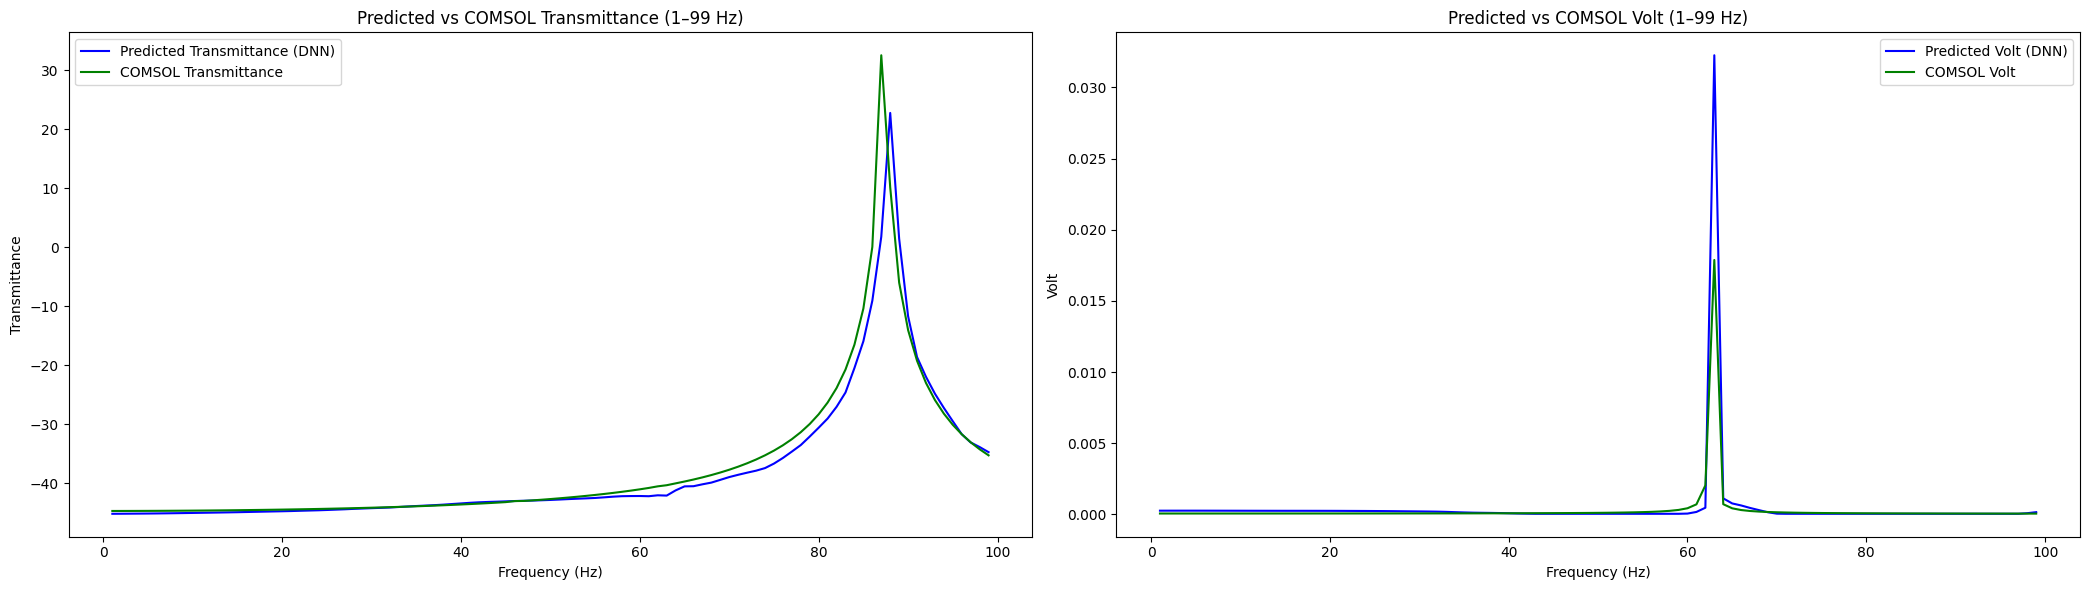

In [9]:
# 시각화
plt.figure(figsize=(21, 6))

# Transmittance
plt.subplot(1, 2, 1)
plt.plot(frequencies, pred_transmittance_dnn, label='Predicted Transmittance (DNN)', color='blue')
plt.plot(comsol_data_filtered['Frequency'], comsol_data_filtered['Transmittance'], label='COMSOL Transmittance', color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Transmittance')
plt.title('Predicted vs COMSOL Transmittance (1–99 Hz)')
plt.legend()

# Volt
plt.subplot(1, 2, 2)
plt.plot(frequencies, pred_volt_dnn, label='Predicted Volt (DNN)', color='blue')
plt.plot(comsol_data_filtered['Frequency'], comsol_data_filtered['Volt'], label='COMSOL Volt', color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Volt')
plt.title('Predicted vs COMSOL Volt (1–99 Hz)')
plt.legend()

plt.tight_layout()
plt.show()

## NSGA 알고리즘을 통한 구조 최적화

![vibration_NSGA](picture/vibration_NSGA.png)

- 딥러닝 모델을 활용하여 NSGA 최적화 진행
- Transmittance, voltage 에 대해 목적함수 f1, f2 설정
- NSGA 알고리즘에 요구되는 하이퍼파라미터 설정

pymoo version : 0.6.1.1

In [12]:
import numpy as np
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pymoo.termination import get_termination

# Transmittance (min-max scaling)
mi0 = df['Transmittance'].min()
ma0 = df['Transmittance'].max()
mi1 = df['Volt'].min()
ma1 = df['Volt'].max()

# 목적 함수 1: 최소 transmittance
def f1(x, freq_range):
    a, b, t1, t2 = x
    X_input = pd.DataFrame([[a, b, t1, t2, freq] for freq in freq_range], columns=features)
    X_scaled = scaler_X.transform(X_input)
    predictions = dnn_model.predict(X_scaled, verbose=0)
    transmittance_pred = predictions[:, 0] * (ma0 - mi0) + mi0

    return np.min(transmittance_pred)

# 목적 함수 2: 최대 Volt (반전하여 최소화 목적)
def f2(x, freq_range):
    a, b, t1, t2 = x
    X_input = pd.DataFrame([[a, b, t1, t2, freq] for freq in freq_range], columns=features)
    X_scaled = scaler_X.transform(X_input)
    predictions = dnn_model.predict(X_scaled, verbose=0)
    volt_pred = predictions[:, 1] * (ma1 - mi1) + mi1
    return -np.max(volt_pred)

# 주파수 범위 설정 (여기서는 45~55Hz 범위만)
freq_ranges = [range(45, 56)]

# 결과 저장용 딕셔너리
optimization_results = {}

# 최적화 실행
for freq_range in tqdm(freq_ranges, desc="Frequency Ranges Optimization"):
    freq_range_str = f"{freq_range.start}-{freq_range.stop - 1} Hz"
    df_filtered = df[df['Frequency'].isin(freq_range)]

    # 목적 함수 리스트 정의
    objs2 = [
        lambda x, freq_range=freq_range: f1(x, freq_range),
        lambda x, freq_range=freq_range: f2(x, freq_range)
    ]

    # 문제 정의 (4개의 설계 변수, 각 하한/상한 포함)
    problem2 = FunctionalProblem(
        n_var=4, # 설계 변수 개수
        objs=objs2, # 목적 함수 리스트
        xl=np.array([0, 0, 0.6, 0.6]), # 각 설계 변수의 하한값
        xu=np.array([20, 1.5, 2.0, 2.0]) # 각 설계 변수의 상한값
    )

    # NSGA-II 알고리즘 설정
    algorithm2 = NSGA2(pop_size=100)

    # 최적화 실행
    res2 = minimize(problem2, algorithm2, termination=('n_gen', 20), seed=1, verbose=False)

    # 결과 저장
    optimization_results[freq_range_str] = {
        "X": res2.X,
        "F": res2.F,
        "filtered_data": df_filtered
    }

Frequency Ranges Optimization: 100%|██████████| 1/1 [01:59<00:00, 119.01s/it]


## 목표 주파수 범위에 대한 NSGA 결과 확인

- 사전에 NSGA 알고리즘 실행 결과 데이터 불러오기
- 파레토 프론트 결과 시각화

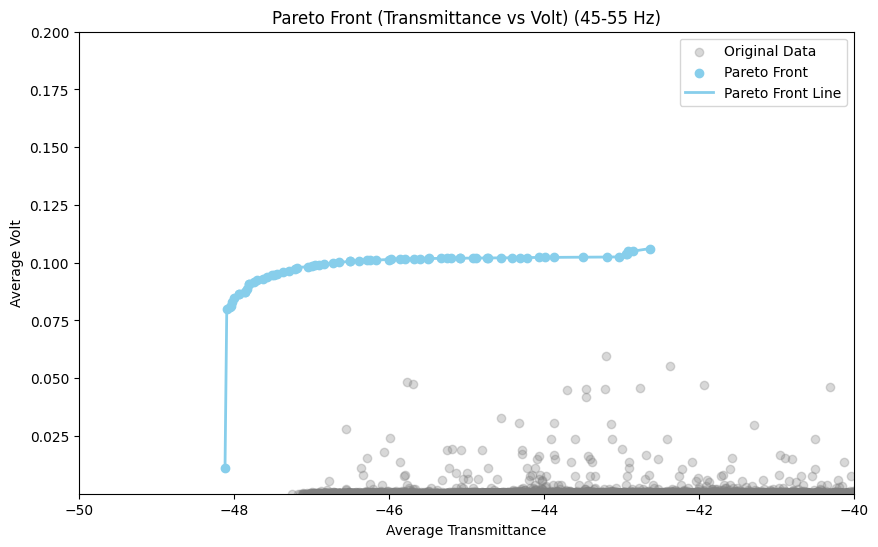

Best solutions found:
            a         b        t1        t2
0   19.834856  0.000493  0.732671  1.219641
1   19.801106  0.000314  0.794356  1.208695
2   19.293550  0.000525  0.789327  1.190598
3   19.280207  0.014280  0.789586  1.219050
4   19.274536  0.012383  0.789724  1.219050
..        ...       ...       ...       ...
65  19.282939  0.000520  0.790089  1.204113
66  19.283016  0.000633  0.790698  1.203273
67  19.280991  0.000480  0.790315  1.203258
68  19.292594  0.000020  0.789724  1.203354
69  19.918602  0.000321  0.724949  1.203110

[70 rows x 4 columns]

Function values (Transmittance and Voltage):
    Transmittance   Voltage
0      -42.629471  0.106132
1      -48.113018  0.011282
2      -48.090408  0.080076
3      -43.494286  0.102372
4      -43.866745  0.102323
..            ...       ...
65     -47.483322  0.094847
66     -45.496872  0.101820
67     -47.285797  0.096607
68     -47.802452  0.090907
69     -42.925282  0.103756

[70 rows x 2 columns]


In [10]:
# 시각화
from scipy.interpolate import make_interp_spline

# 주파수 범위 설정
freq_range_label = "45-55 Hz"
freq_range = range(45, 56)  # 주파수 범위

# 해당 주파수 범위 필터링
df_filtered = df[df['Frequency'].isin(freq_range)]

# -----------------------------
# 파레토 최적화 결과 불러오기
csv_path = r"data/vibration_result/optimization_result_45_55_Hz.csv"
df_result = pd.read_csv(csv_path)

# 파레토 프론트 정렬 및 스플라인 준비
transmittance = df_result['Transmittance'].values
volt = df_result['Voltage'].values
sorted_indices = np.argsort(transmittance)
sorted_transmittance = transmittance[sorted_indices]
sorted_volt = volt[sorted_indices]

unique_transmittance, unique_indices = np.unique(sorted_transmittance, return_index=True)
unique_volt = sorted_volt[unique_indices]

x_new = np.linspace(unique_transmittance.min(), unique_transmittance.max(), 1000)
spl = make_interp_spline(unique_transmittance, unique_volt, k=1)
y_smooth = spl(x_new)

# -----------------------------
# 시각화
plt.figure(figsize=(10, 6))

# 전체 데이터셋 중 해당 주파수 범위의 점
plt.scatter(df_filtered['Transmittance'], df_filtered['Volt'], alpha=0.3, color='gray', label='Original Data')

# 파레토 점 및 선
plt.scatter(unique_transmittance, unique_volt, c='skyblue', label='Pareto Front')
plt.plot(x_new, y_smooth, color='skyblue', linestyle='-', linewidth=2, label='Pareto Front Line')

plt.title(f'Pareto Front (Transmittance vs Volt) ({freq_range_label})')
plt.xlabel('Average Transmittance')
plt.ylabel('Average Volt')
plt.xlim([-50, -40])
plt.ylim([0.00001, 0.2])
plt.legend()
plt.grid(False)
plt.show()

# -----------------------------
# 결과 출력
print("Best solutions found:")
print(df_result[['a', 'b', 't1', 't2']])
print("\nFunction values (Transmittance and Voltage):")
print(df_result[['Transmittance', 'Voltage']])

## 특정 Transmittance 에서 최대 voltage 값을 출력하는 구조 설계 파라미터

In [11]:
threshold_db = -48  # dB 기준 임계값

# 임계값 조건 만족 중 최대 전압 해 찾기
mask = df_result['Transmittance'] <= threshold_db

if mask.any():
    best_idx = df_result[mask]['Voltage'].idxmax()
    best_row = df_result.loc[best_idx]

    print(f"\n📌 Frequency Range: {freq_range_label}")
    print(f"   ▶ Transmittance: {best_row['Transmittance']:.2f} dB")
    print(f"   ▶ Voltage: {best_row['Voltage']:.4f}")
    print(f"   ▶ Parameters:")
    print(f"      a  = {best_row['a']}")
    print(f"      b  = {best_row['b']}")
    print(f"      t1 = {best_row['t1']}")
    print(f"      t2 = {best_row['t2']}")
else:
    print(f"\n📌 Frequency Range: {freq_range_label}")
    print(f"   ❌ {threshold_db} dB 이하의 해가 없습니다.")



📌 Frequency Range: 45-55 Hz
   ▶ Transmittance: -48.00 dB
   ▶ Voltage: 0.0848
   ▶ Parameters:
      a  = 19.29567142797409
      b  = 1.3304737233045018e-05
      t1 = 0.7895741411316157
      t2 = 1.1975431382016688
